In [ ]:
using Flux
using DifferentialEquations
using Plots

In [ ]:
# Define the MLP

# We are working with an NN consisting of the input layer and two hidden layers with 10 neurons each.
# 1 -> 10 -> 10 -> 2
# The call- Dense(Input_size, Output_size, activation_function_handle)



Chain(
  Dense(1 => 10, tanh),                 # 20 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 2),                       # 22 parameters
)                   # Total: 6 arrays, 152 parameters, 920 bytes.

In [ ]:
model = Chain(
  Dense(1 => 10, tanh),  # Input layer (1 neuron) to first hidden layer (10 neurons)
  Dense(10 => 10, tanh), # First hidden layer to second hidden layer
  Dense(10 => 3)         # Second hidden layer to output layer (2 neurons)
)

struct ODEparams
    β::Float32
    γ::Float32
end

function SIR_model!(du, u, params::ODEparams, t)
    S, I, R = u;
    # We always prefer in place modification to reap performance benefits
    du[1] = -params.β*S*I;               #dSdt
    du[2] =  params.β*S*I - params.γ*I;    #dIdt
    du[3] =  params.γ*I;                   #dRdt
end

function Cost_Function(NN_params, NN_model, ODE_model!, ODE_params::ODEparams, Data, t, u0)
    # We need to first take NN(t, θ) and then calculate dNNdt(t, θ). We can compare dNNdt in the ODE Loss. Data Loss will be NN(t, θ)
    function ODELoss()
        # find dNNdt using NN_model(t, NN_params)
        # find ODE_model(NN(t, NN_params), ODEparams)
        # Calculate MSE
        function get_nn_AD()
            #=
            The sum is crucial because it is not obvious why we are doing this. AutoDifferentiation breaks down our mathematical construct into a graph of operators. This graph can then be used to incrementally calculate derivatives, making this a much more precise and efficient operation than a standard numerical derivative. The sum here is required since the zygote.jl needs a scalar to start the differentiation process.
            =#
            # Here we are applying the gradient element wise at each time point in the t vector
            grads = Flux.gradient.(j -> sum(NN_model(j)), t');
        end
        
        dNNdt = get_nn_AD();
        # similar() is the Julia way of initializing an uninitialized matrix of the same structure as the argument
        dudt = similar(dNNdt);
        ODE_model!(dudt, NN(t'), ODE_params, t);
        return Flux.mse(dNNdt, dudt)
    end

    function DataLoss()
        # find NN(t, NN_params)
        # Calculate MSE between this and data
        NN_pred = NN_model(t');
        return Flux.mse(NN_pred, Data);
    end

    return ODELoss() + DataLoss();
end

#=
ODE_param_test = ODEparams(0.5,1.5);
u0 = [5.0, 0.5, 0.0];
time_test = 0.0:0.1:10.0;
prob = DifferentialEquations.ODEProblem(SIR_model!, u0, (time_test[begin], time_test[end]), ODE_param_test);
sol = DifferentialEquations.solve(prob, DifferentialEquations.Tsit5(), saveat=time_test);
sd = 0.5;
noisy_sol = sol .+ randn(size(sol)).*sd;
noisy_sol .= max.(noisy_sol, 0);

plt = Plots.plot(sol)
for i in 1:3
    Plots.scatter!(plt, time_test, noisy_sol[i,:])
end
display(plt)

optimizer = Flux.Adam();
NN_pars = Flux.params(model);


Cost_Function(NN_pars, model, SIR_model!, ODE_param_test, noisy_sol, time_test, u0)


LoadError: ParseError:
[90m# Error @ [0;0m]8;;file://c:/Users/RAS365/OneDrive - University of Pittsburgh/Documents/Research/Projects/Learning-Julia/In[73]#52:1\[90mIn[73]:52:1[0;0m]8;;\

[90m┌─[0;0m
[48;2;120;70;70m#=[0;0m
[48;2;120;70;70mODE_param_test = ODEparams(0.5,1.5);[0;0m
[48;2;120;70;70m[0;0m⋮
[48;2;120;70;70m[0;0m
[48;2;120;70;70mCost_Function(NN_pars, model, SIR_model!, ODE_param_test, noisy_sol, time_test, u0)[0;0m
[48;2;120;70;70m[0;0m[90m#─────────────────────────────────────────────────────────────────────────────────┘ ── [0;0m[91munterminated multi-line comment #= ... =#[0;0m

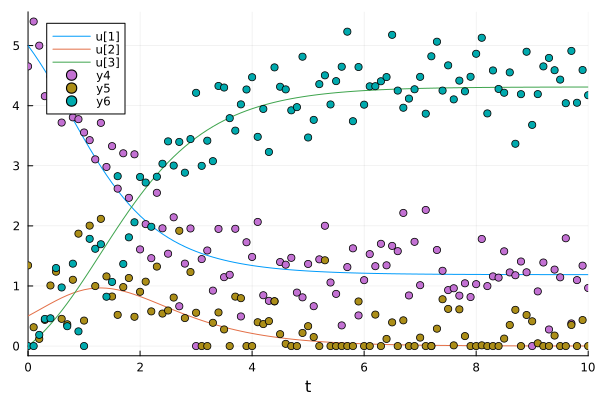

In [72]:
# Generating Synthetic Data 

ODE_param_test = ODEparams(0.5,1.5);
u0 = [5.0, 0.5, 0.0];
time_test = 0.0:0.1:10.0;
prob = DifferentialEquations.ODEProblem(SIR_model!, u0, (time_test[begin], time_test[end]), ODE_param_test);
sol = DifferentialEquations.solve(prob, DifferentialEquations.Tsit5(), saveat=time_test);
sd = 0.5;
noisy_sol = sol .+ randn(size(sol)).*sd;
noisy_sol .= max.(noisy_sol, 0);

plt = Plots.plot(sol)
for i in 1:3
    Plots.scatter!(plt, time_test, noisy_sol[i,:])
end
display(plt)


In [75]:
model(time_test')

3×101 Matrix{Float32}:
 0.0  -0.038943     -0.0761987   …  -0.0396017  -0.0386736  -0.0377608
 0.0  -0.0609331    -0.120029       -0.366806   -0.364903   -0.363021
 0.0  -0.000953766  -0.00242909     -0.107082   -0.106437   -0.105804

In [76]:
Flux.gradient(t -> sum(model(t)), time_test')

([-1.0134344100952148 -0.998094379901886 … 0.034512367099523544 0.034030742943286896],)

0.0:0.1:10.0

In [83]:
Float32.(collect(time_test))'

1×101 adjoint(::Vector{Float32}) with eltype Float32:
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  …  9.4  9.5  9.6  9.7  9.8  9.9  10.0

In [78]:
time_test

0.0:0.1:10.0

LoadError: MethodError: no method matching (Matrix)(::Vector{LinearAlgebra.Adjoint{Float32, Vector{Float32}}})
The type `Matrix` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  (Array{T, N} where T)(::AbstractArray{S, N}) where {S, N}
[0m[90m   @[39m [90mCore[39m [90m[4mboot.jl:603[24m[39m
[0m  (Matrix)([91m::UndefInitializer[39m, [91m::Integer[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mbaseext.jl:33[24m[39m
[0m  (Matrix)([91m::LinearAlgebra.Tridiagonal{T, V} where V<:AbstractVector{T}[39m) where T
[0m[90m   @[39m [36mLinearAlgebra[39m [90mC:\Users\RAS365\.julia\juliaup\julia-1.11.7+0.x64.w64.mingw32\share\julia\stdlib\v1.11\LinearAlgebra\src\[39m[90m[4mtridiag.jl:604[24m[39m
[0m  ...


In [100]:
sol[1,:]

101-element Vector{Float64}:
 5.0
 4.870388725739505
 4.731950190446782
 4.585482440144068
 4.432047050216011
 4.2729514498992165
 4.109689656329652
 3.943893411496266
 3.7772760095260094
 3.6115170921266357
 3.4482214405701708
 3.2888587050701674
 3.1347034392944253
 ⋮
 1.1894580963316752
 1.189304932696763
 1.1891651455744485
 1.1890375498799848
 1.1889210413355218
 1.1888145964701058
 1.1887172767427798
 1.1886283451281703
 1.1885471219486288
 1.1884729417335118
 1.1884051910951448
 1.1883433087288213

3-element Vector{Float32}:
 0.0
 0.0
 0.0

1×303 adjoint(::Vector{Float32}) with eltype Float32:
 -0.392328  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0